<a href="https://colab.research.google.com/github/ahmadhajmosa/Machine-learning-labs/blob/master/Machine_Translation_with_Seq2Seq_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Translation with Seq2Seq model



# sequence to sequence model


![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/01/enc_dec_2.png)

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


# Read the Data into our IDE


In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [4]:
#import urllib.request as urllib2
#data = urllib2.urlopen('https://raw.githubusercontent.com/Apress/applied-natural-language-processing-w-python/master/data_etc/deu.txt')

data = read_text("deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)



deu_eng = deu_eng[:50000,:]


In [5]:
data[0]

'H'

In [6]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['At a moment when our economy is growing our businesses are creating jobs at the fastest pace since the 1990s and wages are starting to rise again we have to make some choices about the kind of country we want to be',
        'In einem Moment in dem unsere Wirtschaft wächst unsere Betriebe so schnell neue Arbeitsplätze schaffen wie zuletzt in den 90ern und die Gehälter steigen müssen wir Entscheidungen treffen und uns überlegen was für ein Land wir sein wollen'],
       ['If someone who doesnt know your background says that you sound like a native speaker it means they probably noticed something about your speaking that made them realize you werent a native speaker In other words you dont really sound like a native speaker',
        'Wenn jemand der deine Herkunft nicht kennt sagt dass du wie ein Muttersprachler sprichst bedeutet das dass man wahrscheinlich etwas an deiner Sprechweise bemerk

In [7]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})




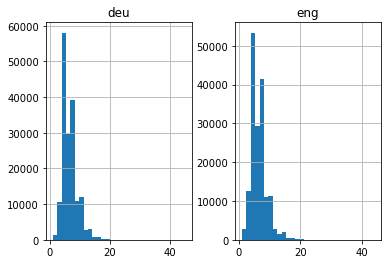

In [8]:
length_df.hist(bins = 30)
plt.show()

In [9]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 15610


In [11]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutsch Vocabulary Size: %d' % deu_vocab_size)

Deutsch Vocabulary Size: 33312


In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [14]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

In [15]:
import keras
from keras.models import Sequential
from keras.layers import Embedding, LSTM, RepeatVector, Dense

# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model

In [16]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [18]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 108680 samples, validate on 27170 samples
Epoch 1/30


InternalError: Blas GEMM launch failed : a.shape=(512, 512), b.shape=(512, 512), m=512, n=512, k=512
	 [[{{node lstm_1/while/MatMul_6}}]]
	 [[{{node loss/mul}}]]

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [ ]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [ ]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

In [ ]:
preds_text = []
for i in preds:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], eng_tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
# print 15 rows randomly
pred_df.sample(15)

model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [19]:
print("Fin :D")

Fin :D
